In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

## Load data

In [85]:
# Function to read a CSV file for a given stock and date
def read_csv_file(stock, date):
    dt = datetime.strptime(date, "%Y%m%d")
    year = dt.year
    month = dt.month

    def get_last_thursday(y, m):
        if m == 12:
            last_day = datetime(y + 1, 1, 1) - timedelta(days=1)
        else:
            last_day = datetime(y, m + 1, 1) - timedelta(days=1)
        offset = (last_day.weekday() - 3) % 7  # Thursday is 3
        return last_day - timedelta(days=offset)

    last_thurs_current = get_last_thursday(year, month)

    # If last Thursday of current month is before the input date,
    # get last Thursday of next month
    if last_thurs_current < dt:
        # increment month/year for next month
        if month == 12:
            next_month = 1
            next_year = year + 1
        else:
            next_month = month + 1
            next_year = year
        last_thurs = get_last_thursday(next_year, next_month)
    else:
        last_thurs = last_thurs_current

    last_thurs_str = last_thurs.strftime("%Y%m%d")

    file_path = f"{stock}/{year}/{year}_new/{stock}_{date}_{last_thurs_str}_Intraday_Preprocessed.csv"

    try:
        return pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

## Backtesting function

In [ ]:
import numpy as np
import pandas as pd

def simulate_hedged_straddle_day(
    dfs,                  # list of DataFrames for each stock
    stocks,
    weights,
    start_date,
    hedge_interval_minutes,
    lot_sizes,            # list of lot sizes per stock, e.g. [75, 125]
    r=0.06,
    dividend_yield=0.0,
    cash=1_000_000,
    transaction_cost_per_unit=0.0  # cost per option contract traded
):
    # Prepare combined df_all_stocks with correct indexing and sorting
    processed_dfs = []
    for df in dfs:
        df = df.rename(columns={'Date Time': 'Timestamp'})
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        if 'Instrument' in df.columns:
            df['Stock'] = df['Instrument']
        else:
            raise ValueError("Each input df must have 'Instrument' column for stock name")
        processed_dfs.append(df)

    df_all_stocks = pd.concat(processed_dfs, ignore_index=True)
    index_cols = ['Timestamp', 'Stock', 'Strike', 'Type']
    df_all_stocks.set_index(index_cols, inplace=True)
    df_all_stocks.sort_index(inplace=True)

    df = df_all_stocks[df_all_stocks.index.get_level_values('Timestamp').date == pd.to_datetime(start_date).date()]

    # Hedge times
    start_time = pd.to_datetime(str(start_date) + ' 09:15:00')
    end_time = pd.to_datetime(str(start_date) + ' 15:15:00')
    hedge_times = pd.date_range(start=start_time, end=end_time, freq=f'{hedge_interval_minutes}min')

    # Helper to find closest timestamp in df for a given target_time
    def get_closest_timestamp(target_time):
        timestamps = df.index.get_level_values('Timestamp').unique()
        if target_time in timestamps:
            return target_time
        else:
            try:
                idx = timestamps.get_loc(target_time, method='ffill')
                return timestamps[idx]
            except KeyError:
                return timestamps[0]

    # Initialize portfolio
    hedge_positions = {stock: 0.0 for stock in stocks}  # position = contracts held (signed)
    cash = float(cash)
    pnl_records = []

    # Track ITM loss on short options
    itm_loss = 0.0

    if len(lot_sizes) != len(stocks):
        raise ValueError("lot_sizes length must match stocks length")

    for current_time in hedge_times:
        actual_time = get_closest_timestamp(current_time)

        option_values = []
        total_deltas = []

        for i, (stock, weight) in enumerate(zip(stocks, weights)):
            lot = lot_sizes[i]
            try:
                df_stock = df.xs(stock, level='Stock')
                spot = df_stock['Spot'].iloc[0]
                strikes = df_stock.index.get_level_values('Strike').unique()
                atm_strike = strikes[np.abs(strikes - spot).argmin()]

                # Fetch mid prices for CE and PE at actual_time and strike
                try:
                    ce_price = float(df.loc[(actual_time, stock, atm_strike, 'CE'), 'mid_price'])
                    pe_price = float(df.loc[(actual_time, stock, atm_strike, 'PE'), 'mid_price'])
                except KeyError:
                    # Debug print for missing option prices
                    print(f"Missing mid_price at {actual_time} for {stock} strike {atm_strike}")
                    option_values.append(0.0)
                    total_deltas.append(0.0)
                    continue

                # Straddle value scaled by weight and lot size (total contracts)
                straddle_value = (ce_price + pe_price) * lot * weight

                # Get deltas, scale by weight and lot size
                ce_delta = float(df.loc[(actual_time, stock, atm_strike, 'CE'), 'Delta'])
                pe_delta = float(df.loc[(actual_time, stock, atm_strike, 'PE'), 'Delta'])
                total_delta = (ce_delta + pe_delta) * lot * weight

                option_values.append(straddle_value)
                total_deltas.append(total_delta)
            except KeyError:
                print(f"Missing data for {stock} at {actual_time}")
                option_values.append(0.0)
                total_deltas.append(0.0)
                continue

        # Hedge adjustment
        total_delta = sum(total_deltas)

        for i, (stock, weight) in enumerate(zip(stocks, weights)):
            lot = lot_sizes[i]
            old_pos = hedge_positions[stock]

            # Hedge position to neutralize total delta scaled by weight and lot
            # Your original strategy does hedge per underlying option delta:
            # new_pos = -w_j * d_j^t * lot_j
            # Here, we should hedge individually per stock delta, not total_delta * weight again

            # Let's calculate individual stock option delta:
            indiv_delta = total_deltas[i]

            new_pos = -indiv_delta  # hedge position in shares/contracts
            trade_qty = new_pos - old_pos
            trade_cost = abs(trade_qty) * transaction_cost_per_unit
            cash -= trade_cost
            hedge_positions[stock] = new_pos

            # Hedge value change: multiply by spot price to adjust cash accordingly
            try:
                spot_price = df.loc[(actual_time, stock, atm_strike, 'CE'), 'Spot']
            except KeyError:
                spot_price = df.xs(stock, level='Stock')['Spot'].iloc[0]
            cash -= trade_qty * spot_price

        option_value_total = sum(option_values)
        hedge_value = sum(hedge_positions[stock] * df.loc[(actual_time, stock, atm_strike, 'CE'), 'Spot'] for stock in stocks if (actual_time, stock, atm_strike, 'CE') in df.index)
        total_portfolio_value = option_value_total + hedge_value + cash

        pnl_records.append({
            "Timestamp": current_time,
            "OptionValue": option_value_total,
            "HedgeValue": hedge_value,
            "Cash": cash,
            "TotalValue": total_portfolio_value
        })

    # End of day unwind and ITM loss calculation
    final_time = hedge_times[-1]
    actual_final_time = get_closest_timestamp(final_time)

    for i, stock in enumerate(stocks):
        lot = lot_sizes[i]
        try:
            df_final = df.xs(stock, level='Stock')
            atm_strikes = df_final.index.get_level_values('Strike').unique()
        except KeyError:
            continue

        for strike in atm_strikes:
            try:
                ce_row = df.loc[(actual_final_time, stock, strike, 'CE')]
                pe_row = df.loc[(actual_final_time, stock, strike, 'PE')]
            except KeyError:
                continue

            spot = ce_row['Spot']

            # Calculate ITM loss based on ATM strike only:
            if strike == np.abs(strike - spot).argmin() + spot - strike:  # More robust is:
                atm_strike = strike
                if spot > atm_strike:
                    itm_loss += lot * ce_row['mid_price']
                if spot < atm_strike:
                    itm_loss += lot * pe_row['mid_price']

        # Close options by adding their value to cash
        try:
            ce_val = df.loc[(actual_final_time, stock, atm_strike, 'CE'), 'mid_price']
            pe_val = df.loc[(actual_final_time, stock, atm_strike, 'PE'), 'mid_price']
            cash += lot * (ce_val + pe_val)
        except KeyError:
            pass

        # Close hedge positions to cash
        old_pos = hedge_positions[stock]
        try:
            spot_price = df.loc[(actual_final_time, stock, atm_strike, 'CE'), 'Spot']
        except KeyError:
            spot_price = df.xs(stock, level='Stock')['Spot'].iloc[0]
        cash += old_pos * spot_price
        hedge_positions[stock] = 0

    total_portfolio_value = cash  # after closing all positions

    pnl_df = pd.DataFrame(pnl_records)
    final_report = {
        "final_cash": cash,
        "itm_loss": itm_loss
    }

    return pnl_df, total_portfolio_value, final_report


## Use case

In [234]:
hedge_intervals = 5 # hedge interval in minutes
weight = [0.5,0.5] # weights for the two assets
stocks = ["BAJAJ-AUTO", "BAJFINANCE"] # Stock symbols
start_date = "20240403"

In [235]:
# Lot_sizes
df = pd.read_csv('NIFTY_200_Lot_Size.csv')
df['Symbol'] = df['Symbol'].str.strip().str.upper()
df['LOT_SIZE'] = pd.to_numeric(df['LOT_SIZE'], errors='coerce')

lot_sizes = []

for symbol in stocks:
    symbol = symbol.strip().upper()
    lot_size_row = df[df['Symbol'] == symbol]

    if not lot_size_row.empty:
        lot_size = lot_size_row['LOT_SIZE'].values[0]
    else:
        lot_size = None

    lot_sizes.append(lot_size)

In [236]:
S_1 = read_csv_file(stocks[0], start_date)
S_2 = read_csv_file(stocks[1], start_date)

In [237]:
S_1.columns

Index(['Date Time', 'ExchToken', 'BidPrice', 'BidQty', 'AskPrice', 'AskQty',
       'TTq', 'LTP', 'TotalTradedPrice', 'Instrument', 'ExpiryDate',
       'ExpiryTime', 'Strike', 'Type', 'ExpiryDateTime', 'Spot',
       'Time_to_expire', 'Delta', 'Theta', 'Gamma', 'Vega', 'Sigma',
       'bid_ask_spread', 'mid_price', 'Intrinsic_value', 'bid_ask_move',
       'price_problem', 'is_tradable', 'bid_plus', 'ask_minus'],
      dtype='object')

In [ ]:
pnl_df, total_value, final_report = simulate_hedged_straddle_day(
    [S_1, S_2],  
    stocks=stocks,
    weights=weight,
    start_date=start_date,
    hedge_interval_minutes=hedge_intervals,
    lot_sizes=lot_sizes,
    r=0.06,
    dividend_yield=0.0,
    cash=1000000,
    transaction_cost_per_unit=0.01
)

/tmp/ipykernel_3879/3031609173.py:48: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  idx = timestamps.get_loc(target_time, method='ffill')


In [240]:
print("Final Total Portfolio Value:", total_value)
print("\nFinal Report:")
for key, value in final_report.items():
    print(f"{key}: {value}")

print("\nPnL DataFrame (first few rows):")
print(pnl_df.head())


Final Total Portfolio Value: 1048080.087074293

Final Report:
final_cash: 1048080.087074293
itm_loss: 0.0

PnL DataFrame (first few rows):
            Timestamp  OptionValue    HedgeValue          Cash    TotalValue
0 2024-04-03 09:15:00   41530.3125   1859.569701  1.015973e+06  1.059362e+06
1 2024-04-03 09:20:00   42218.4375 -22319.998299  1.047742e+06  1.067640e+06
2 2024-04-03 09:25:00   42504.3750 -22096.163800  1.038602e+06  1.059010e+06
3 2024-04-03 09:30:00   42622.5000 -29120.246898  1.052560e+06  1.066062e+06
4 2024-04-03 09:35:00   42764.0625 -26360.034411  1.042884e+06  1.059288e+06


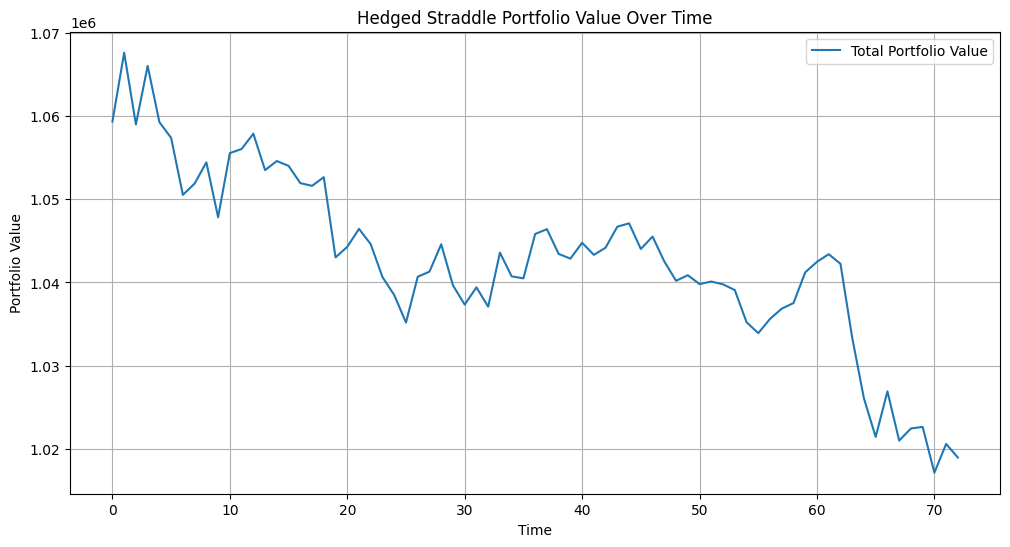

In [241]:
plt.figure(figsize=(12, 6))
plt.plot(pnl_df.index, pnl_df['TotalValue'], label='Total Portfolio Value')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.title('Hedged Straddle Portfolio Value Over Time')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def run_yearly_backtest(
    year,
    stocks,
    weights,
    lot_sizes,  
    hedge_interval_minutes=5,
    initial_cash=1000000
):
    cash = initial_cash
    full_pnl_df = pd.DataFrame()
    start_date = datetime(year, 1, 1)
    end_date = datetime(year, 12, 31)

    current_date = start_date
    while current_date <= end_date:
        date_str = current_date.strftime('%Y%m%d')

        dfs = [read_csv_file(stock, date_str) for stock in stocks]

        if all(df is not None for df in dfs):
            print(f"Running backtest for date: {date_str}")
            try:
                pnl_df, total_val, report = simulate_hedged_straddle_day(
                    dfs=dfs,
                    stocks=stocks,
                    weights=weights,
                    start_date=current_date,
                    hedge_interval_minutes=hedge_interval_minutes,
                    lot_sizes=lot_sizes,
                    cash=cash
                )
                cash = report['final_cash']  # carry forward cash
                pnl_df['Date'] = current_date.date()
                full_pnl_df = pd.concat([full_pnl_df, pnl_df], ignore_index=True)
            except Exception as e:
                print(f"Error on {date_str}: {e}")
        else:
            print(f"Data missing for one or more stocks on {date_str}")

        current_date += timedelta(days=1)

    return cash, full_pnl_df

In [ ]:
hedge_intervals = 5 # hedge interval in minutes
weight = [0.5,0.5] # weights for the two assets
stocks = ["BAJAJ-AUTO", "BAJFINANCE"] # Stock symbols
start_date = "20240403"

In [243]:
df = pd.read_csv('NIFTY_200_Lot_Size.csv')
df['Symbol'] = df['Symbol'].str.strip().str.upper()
df['LOT_SIZE'] = pd.to_numeric(df['LOT_SIZE'], errors='coerce')
lot_size_map = dict(zip(df['Symbol'], df['LOT_SIZE']))

lot_sizes = [lot_size_map.get(symbol.strip().upper()) for symbol in stocks]

In [ ]:
final_cash, yearly_pnl = run_yearly_backtest(
    year=2024,
    stocks=stocks,
    weights=weight,
    lot_sizes=lot_sizes
)

In [246]:
print(f"\nFinal Cash: ₹{final_cash:,.2f}")


Final Cash: ₹11,981,805.14


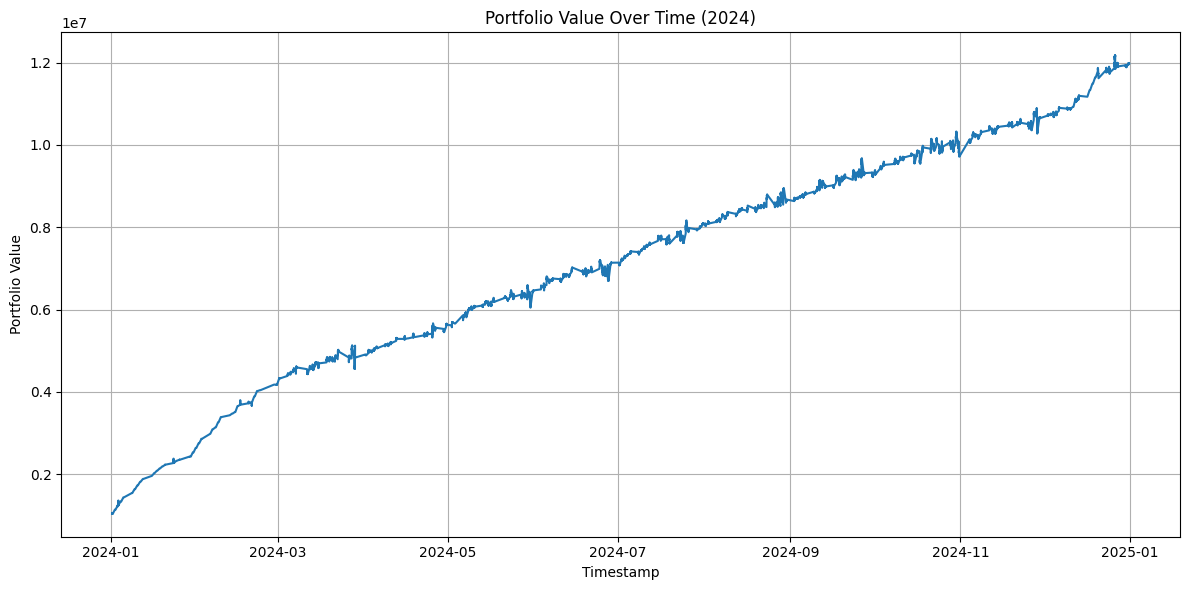

In [247]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(yearly_pnl['Timestamp']), yearly_pnl['TotalValue'])
plt.title("Portfolio Value Over Time (2024)")
plt.xlabel("Timestamp")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.tight_layout()
plt.show()
